# Data analysis

Author(s): Maya Fishbach, modified from Carl Haster


## Bayes' Theorem

On the whiteboard, derive Bayes' theorem from the *joint* probability distribution $p(A, B) = p(A | B)p(B) = p(B|A)p(A),$ where $p( A | B)$ is a *conditional* distribution and $p(A) = \int p(A , B) dB$ is a *marginal* distribution.

$$ p(A|B) = \frac{p(A) p(B|A)}{p(B)} $$

or choosing special symbols for parameters we're trying to measure ($\theta$), data ($d$), hypothesis/ model ($I$), prior ($\pi$), likelihood ($L$) and evidence ($Z$):

$$ p(\theta|d, I) = \frac{\pi(\theta | I) L(d|\theta, I)}{Z(d | I)} $$

where $p(\theta|d)$ is a posterior probability function which describes the probability of parameters $\theta$ given some data $d$ and our hypothesis/ model $I$. This posterior depends on a likelihood $L(d|\theta, I)$ (how likely the data realization is given $\theta$ and our model $I$), a prior probability $\pi(\theta | I)$ (what are our beliefs about $\theta$ before we've seen the data) and normalized by the evidence $Z(d | I)$, also known as the marginal likelihood (how good is the assumed model $I$ at describing the data $d$).

The evidence can be useful if we are compairing two models $H$ and $I$. Then the Bayes factor is:
$$B^H_I = \frac{Z(d | H)}{Z(d | I)}$$
and the Bayesian odds is the Bayes factor multiplied by the prior odds:
$$O^H_I = \frac{p(H | d)}{p(I | d)} = B^H_I \frac{p(H)}{p(I)}$$

## Signal processing example


### Define a sine-Gaussian signal

Consider a sine-Gaussian signal in noisy timeseries data. Assume we know everything about the signal other than its central or peak time $\tau$. Therefore, in this example $\theta = \tau$. 

In [1]:
import numpy as np

import matplotlib 
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (5, 3)
import matplotlib.pyplot as plt

In [2]:
def sinGauss(t, tau, A = 1, f = 3, s = 1):

    '''return sine-Gaussian pulse on time array t
    
    inputs: t -- array of times
            tau -- float, central time
            A -- float, amplitude of signal
            f -- float, central frequency of signal
            s -- float, width of Gaussian

    returns: sine-Gaussian pulse -- array of same shape as t
    '''

    return A * np.sin(2 * np.pi * f * t) * np.exp(-np.square(t-tau)/(2*np.square(s)))


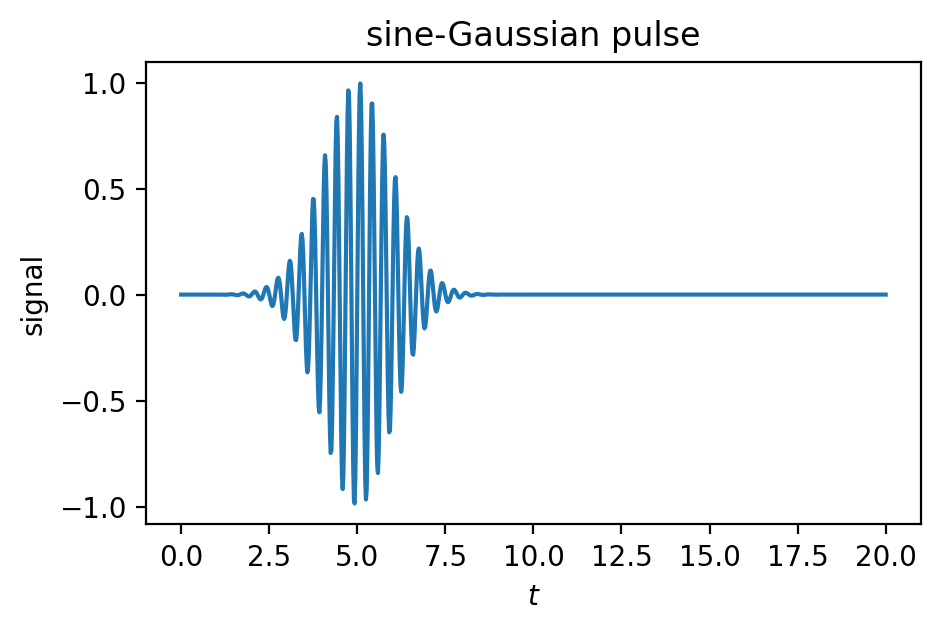

In [3]:
t = np.linspace(0, 20, 1000)

tau_true = 5

signal = sinGauss(t, tau_true)

plt.plot(t, signal)
plt.xlabel('$t$')
plt.ylabel('signal')
plt.title('sine-Gaussian pulse')
plt.show()

### Introduce Gaussian noise

This signal will be hidden in noise, where the random process generating the noise is a zero-mean Gaussian process with a known standard deviation (white Gaussian noise). 

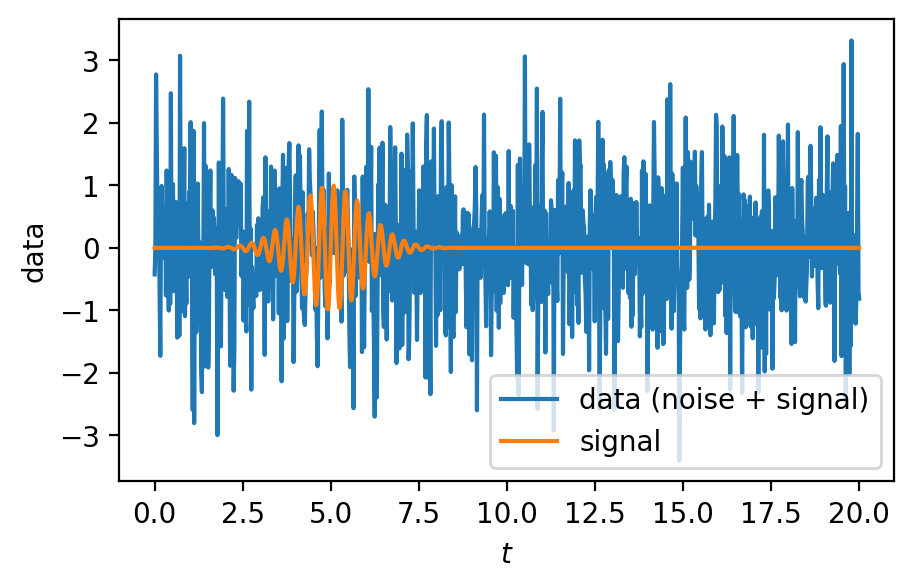

In [4]:
noise_sigma = 1

noise = np.random.normal(0, noise_sigma, t.size)

data = noise + signal

plt.plot(t, data, label = 'data (noise + signal)')
plt.plot(t, signal, label = 'signal')
plt.xlabel(r'$t$')
plt.ylabel('data')
plt.legend(loc = 'best')
plt.show()

### Define the likelihood

We know the statistical properties of the noise, so we use this to define our likelihood. 
\
*noise = data - signal*
\
We want to know the central location of the signal, $\tau$, so we define the likelihood for the data given this parameter. 
It's helpful to work in the logarithm of probabilities (they tend to be easier to keep track of numerically)

$$ \log L(d|\tau) \propto -\frac{1}{2} \int^{t_{max}}_{t_{min}}\frac{(d(t)-Signal(t,\tau))^2}{\sigma_{noise}^2}dt$$

(compare to [$\chi^2$-test](https://en.wikipedia.org/wiki/Chi-squared_test))


In [5]:
def log_likelihood(data, t, tau, A=1, f = 3, s = 1, sigma_noise=1):
    
    logL = -0.5*np.trapezoid(np.square((data - sinGauss(t,tau,A,f,s))/sigma_noise), t) #use trapezoidal integration

    return logL

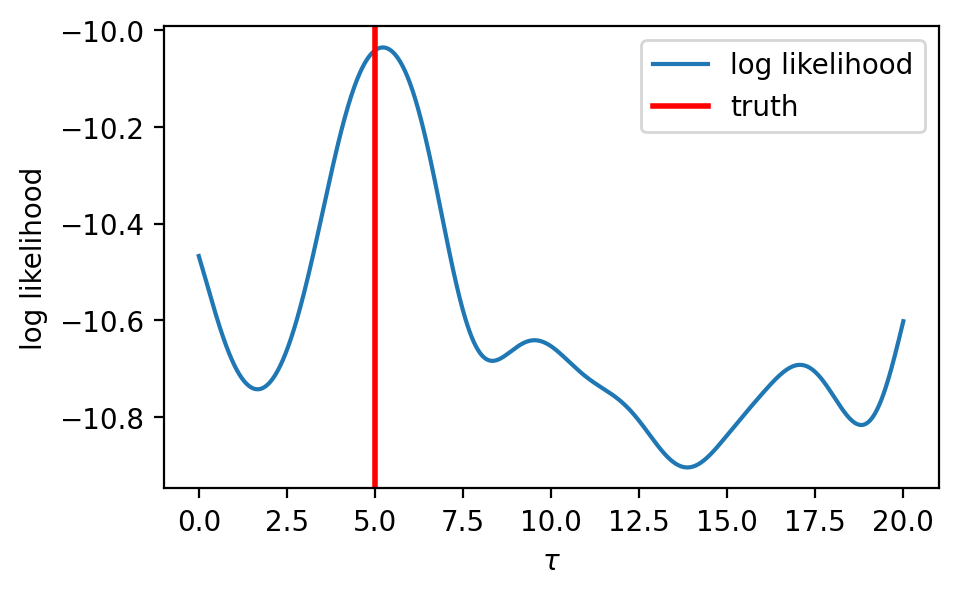

In [6]:
logL = np.zeros_like(t)

#calculate log likelihood on a grid of possible tau values (which can be any time in t). 
#Note that all other parameters are fixed to their true values.

for i in range(t.shape[0]):

    tau = t[i]

    logL[i] = log_likelihood(data, t, tau)

plt.plot(t, logL, label = 'log likelihood')
plt.axvline(tau_true, lw=2, c = 'r', label = 'truth')
plt.legend(loc = 'best')
plt.xlabel(r'$\tau$')
plt.ylabel('log likelihood')
plt.show()

The maximum log likelihood is pretty close to the true value!


### Choose a prior
Now let's turn that likelihood into a posterior, by taking into account a prior (ideally, you would do this before you ever looked at the data).
\
Let's start with a flat prior, assuming $\tau$ lies somewhere inside the range $a < \tau < b$ where each point has equal probability. This gives

$$ \pi(\tau) = \frac{1}{b - a}$$

In [7]:
def log_prior_uniform(t, t_min, t_max):
    
    logprior = np.zeros_like(t)
    
    inside_range = np.logical_and(np.greater_equal(t, t_min),\
                                  np.less_equal(t, t_max))
    
    logprior[inside_range] = -np.log(t_max - t_min)
    
    logprior[np.logical_not(inside_range)] = -np.inf
    
    return logprior

### What about the evidence?

The evidence is merely a normalization term to ensure that the posterior integrates to 1 over all possible $\tau$:

$$Z(d) = \int^{\infty}_{-\infty}\pi(\tau) L(d|\tau) d\tau$$

### Putting together likelihood, prior and evidence for the posterior:

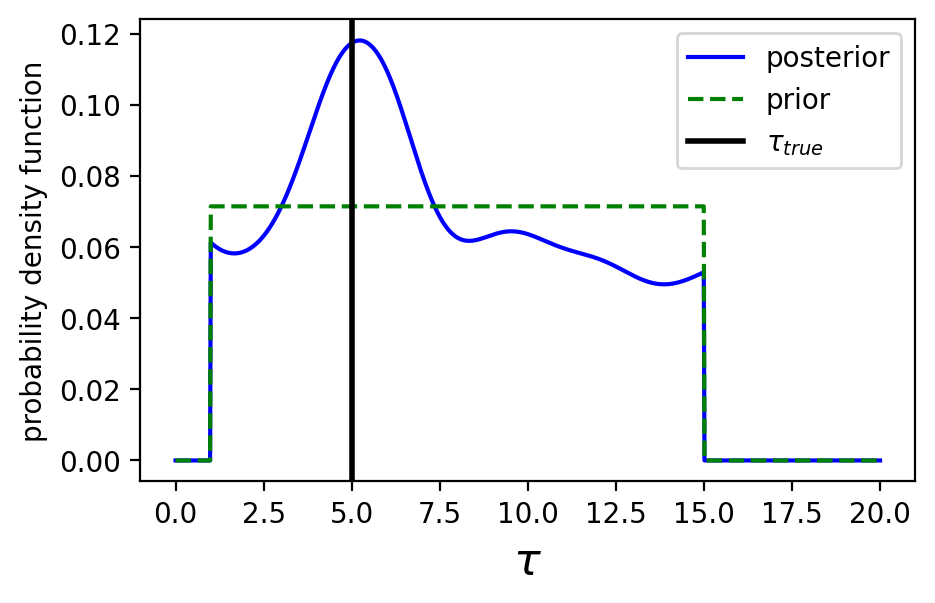

In [8]:
log_prior_1 = log_prior_uniform(t, 1, 15)

log_evidence_1 = np.log(np.trapezoid(np.exp(log_prior_1 + logL), t))

log_posterior_1 = log_prior_1 + logL - log_evidence_1

plt.plot(t, np.exp(log_posterior_1), c='b', label='posterior')
plt.plot(t, np.exp(log_prior_1), c='g', label='prior', ls = '--')
plt.axvline(tau_true, c='k', lw=2, label=r'$\tau_{true}$')
plt.legend(loc='best')
plt.xlabel(r'$\tau$', fontsize=16)
plt.ylabel('probability density function')
plt.show()

Exercise: can you compute a posterior under a different prior choice? Can you calculate the Bayes' factor (ratio of evidences) between the two priors? 

### Fitting for 2 parameters simultaneously

What if we want to fit an additional parameter of the signal in addition to its location? For example, let's fit the standard deviation of the Gaussian envelope $s$

In [15]:
s_to_test = np.linspace(0.1,3,300)

taus_to_test = np.linspace(0.1,10, 100)

logL2 = np.zeros([taus_to_test.shape[0], s_to_test.shape[0]])

#evaluate the likelihood on a grid of possible peak times tau and standard deviations s

for i in range(taus_to_test.shape[0]):
    for j in range(s_to_test.shape[0]):

        tau = taus_to_test[i]
        s = s_to_test[j]

        logL2[i,j] = log_likelihood(data, t, tau, s = s)        

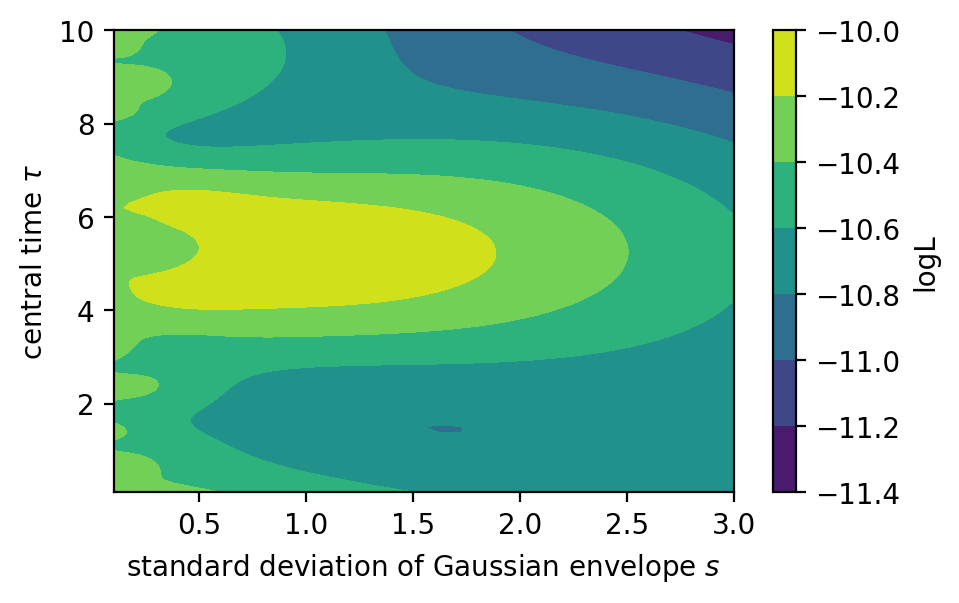

In [16]:
plt.contourf(s_to_test, taus_to_test, logL2)
plt.xlabel(r'standard deviation of Gaussian envelope $s$')
plt.ylabel(r'central time $\tau$')
plt.colorbar(label = 'logL')

Let's compute the posterior, given flat priors over the same ranges in $\tau$ and $s$ as we calculated the log likelihood over.  
\
In this case, the posterior is proportional to the likelihood, and we just have to make sure the posterior is normalized.

In [17]:
def posterior_given_2d_logL(xi, xj, logL):

    '''calculate the posterior p(xi, xj) given the log likelihood defined over a grid of xi, xj and a flat prior

    inputs:
    xi -- array
    xj -- array
    logL -- array of shape (len(xi), len(xj)), where logL[i,j] is the log likelihood evaluated at xi[i], xj[j]

    output:
    post -- array of same shape as logL
    '''

    log_evidence = np.log(np.trapezoid(np.trapezoid(np.exp(logL), xj, axis = -1), xi, axis = -1))

    log_post = logL - log_evidence

    return np.exp(log_post)

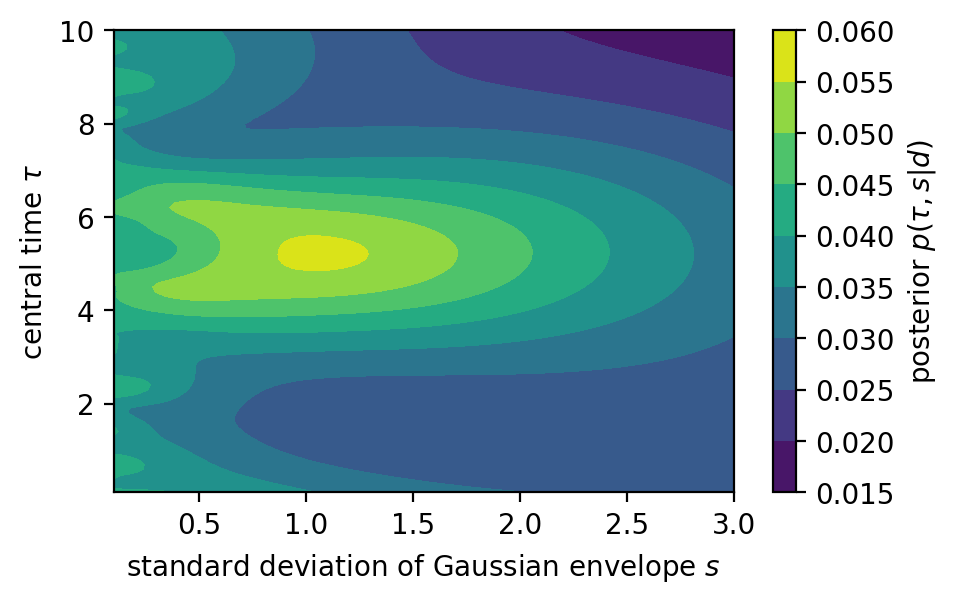

In [18]:
post_tau_s = posterior_given_2d_logL(taus_to_test, s_to_test, logL2)

plt.contourf(s_to_test, taus_to_test, post_tau_s)
plt.xlabel(r'standard deviation of Gaussian envelope $s$')
plt.ylabel(r'central time $\tau$')
plt.colorbar(label = r'posterior $p(\tau, s | d)$')

From the 2-dimensional posterior, we can also calculate the 1-dimensional posterior over $\tau$ *marginalizing over s* (as opposed to the posterior over $\tau$ for a fixed $s$, which is what we had before). Similarly, we can calculate the posterior over $s$ marginalizing over $\tau$. 

In [19]:
post_tau = np.trapezoid(post_tau_s, s_to_test, axis = -1)
post_s = np.trapezoid(post_tau_s, taus_to_test, axis = 0)

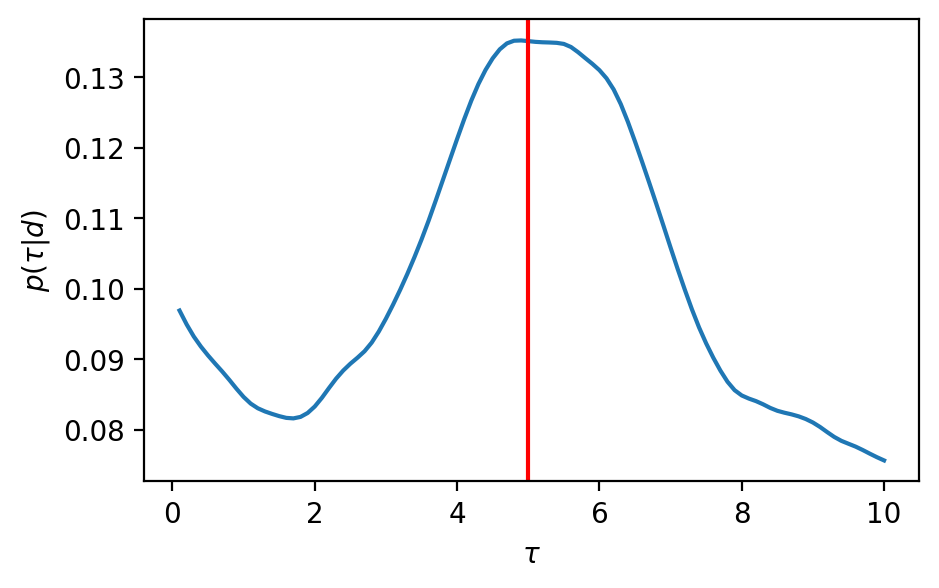

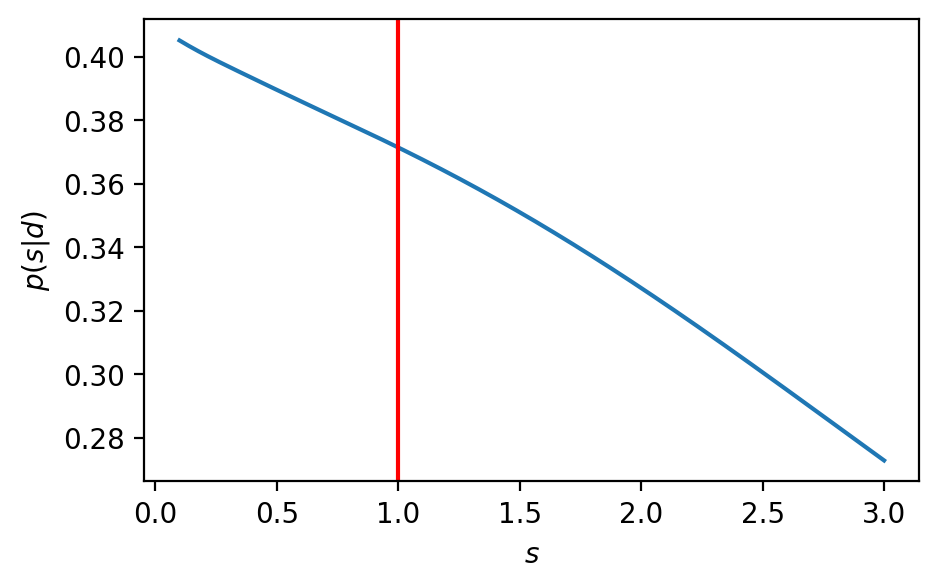

In [20]:
plt.plot(taus_to_test, post_tau)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$p(\tau | d)$')
plt.axvline(tau_true, c = 'r')
plt.show()

plt.plot(s_to_test, post_s)
plt.xlabel(r'$s$')
plt.ylabel(r'$p(s | d)$')
s_true = 1
plt.axvline(s_true, c = 'r')
plt.show()

### Exercises

* Consider other prior choices (instead of the flat priors assumed here) and update your posterior for each prior choice.
* Calculate Bayes factors between different prior choices.
* Try to fit for other combinations of signal parameters, such as the amplitude or frequency in addition to the central time and width of the pulse
* Vary the amplitude of the signal or the standard deviation of the noise to see how it affects your measurement of the signal parameters.